In [20]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

In [21]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header=None, names=columns)
df = df.dropna()

In [22]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


<AxesSubplot:title={'center':'Training examples by activity type'}>

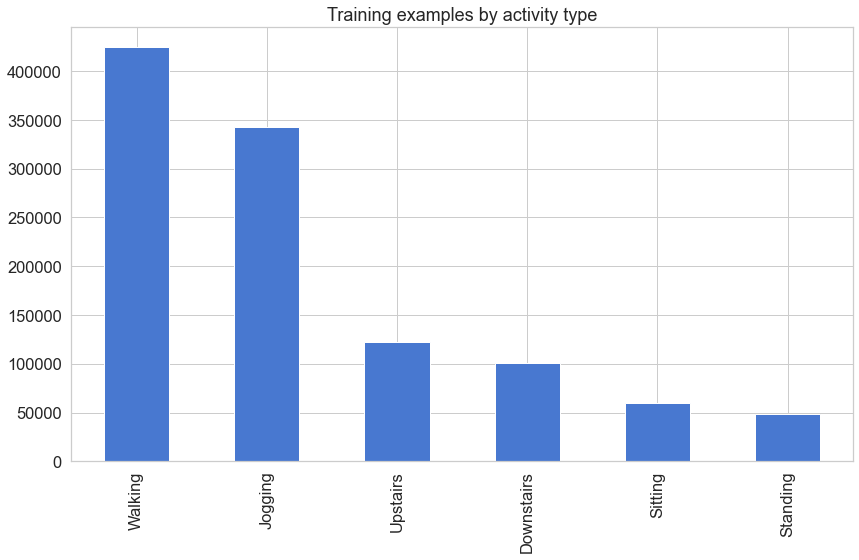

In [24]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type')

<AxesSubplot:title={'center':'Training examples by user'}>

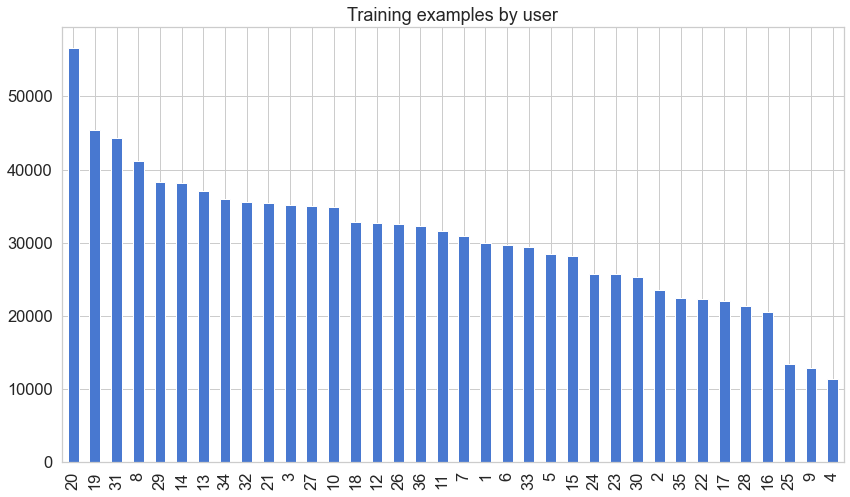

In [25]:
df['user'].value_counts().plot(kind='bar', title='Training examples by user')

In [26]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][: 200]
    axis = data.plot(subplots=True, figsize=(16, 12), title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

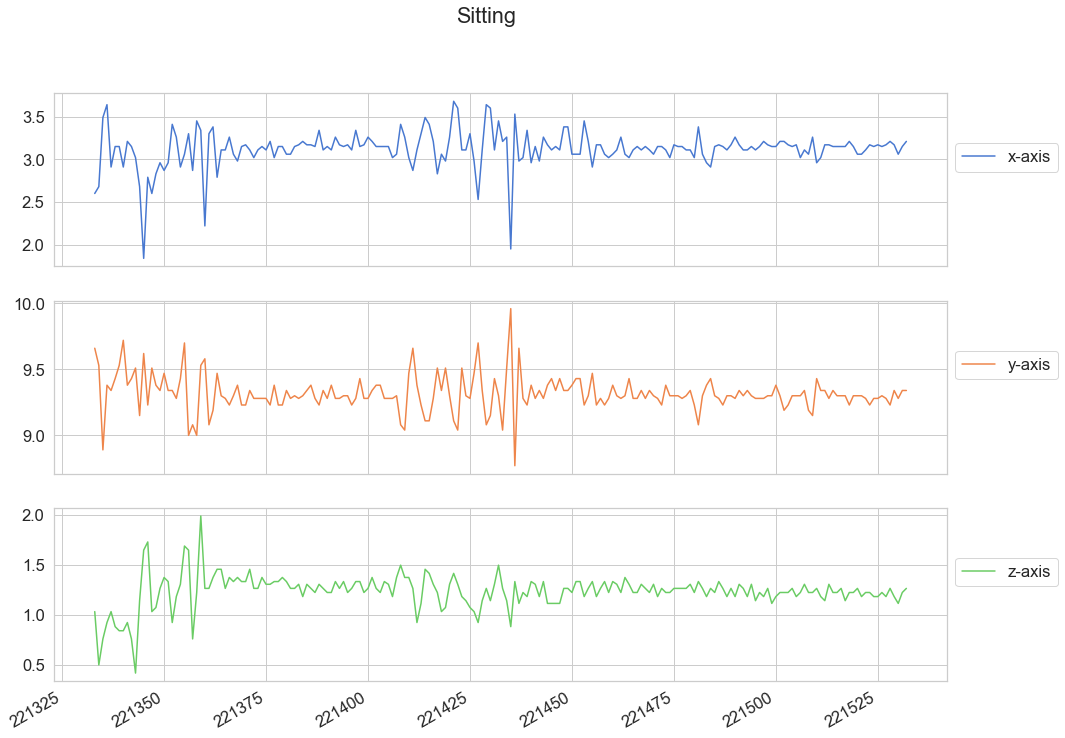

In [27]:
plot_activity("Sitting", df)

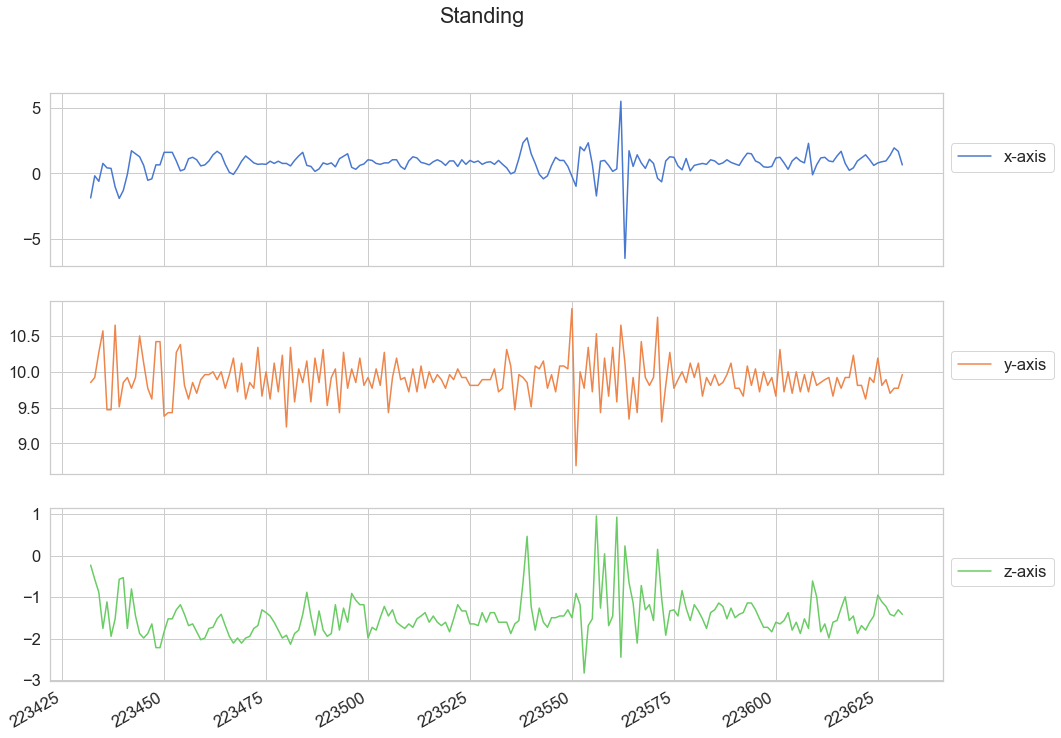

In [28]:
plot_activity("Standing", df)

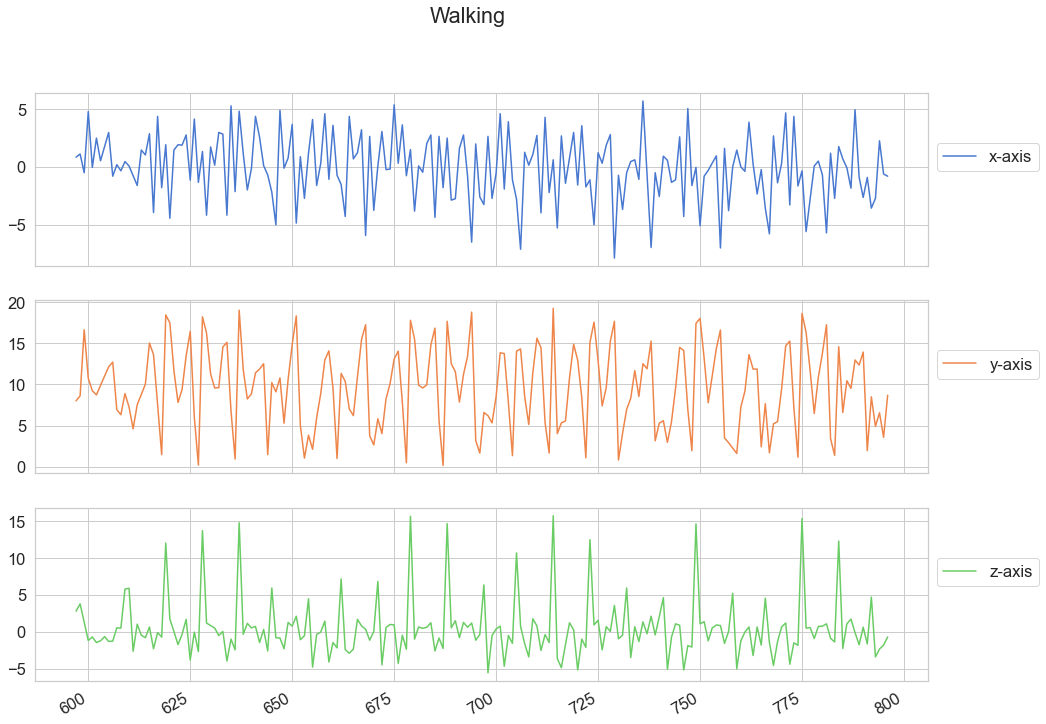

In [29]:
plot_activity("Walking", df)

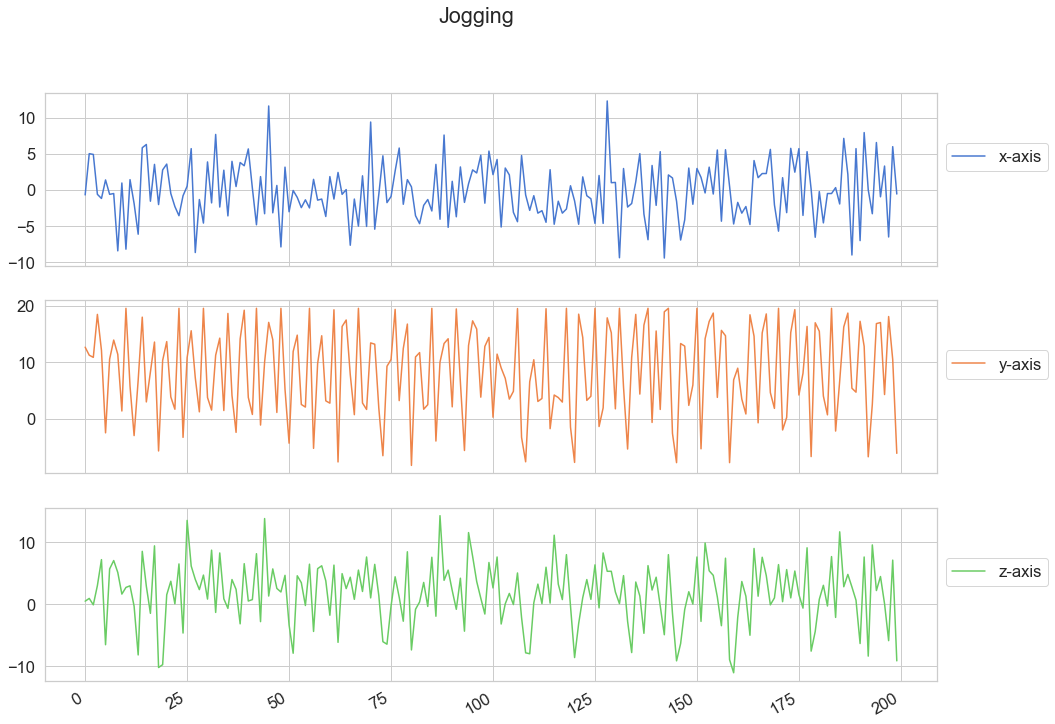

In [30]:
plot_activity("Jogging", df)

In [31]:
# 将固定长度的序列作为训练数据，在此处我们设置每个序列包含200个训练数据，为下面的LSTM做铺垫
from scipy import stats
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i : i + N_TIME_STEPS]
    ys = df['y-axis'].values[i : i + N_TIME_STEPS]
    zs = df['z-axis'].values[i : i + N_TIME_STEPS]
    # 每一个序列将出现次数最多的标签作为该序列的标签
    label = stats.mode(df['activity'][i : i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [32]:
np.array(segments).shape

(54901, 3, 200)

In [33]:
reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)

In [34]:
reshaped_segments.shape

(54901, 200, 3)

In [35]:
labels[0]

array([0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
N_CLASSES = 6
N_HIDDEN_UNITS = 64

def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random.normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random.normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random.normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random.normal([N_CLASSES]))
    }

    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    lstm_layers = [layers.LSTMCell]